In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

# Read in data and do basic massaging

In [2]:
df_us_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_us_raw.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,15,27,29,32,37,45,51,55,56,58


In [3]:
df_global_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243


In [4]:
print(df_us_raw.columns)
print(df_global_raw.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/2020',
       '1/23/2020', '1/24/2020', '1/25/2020', '1/26/2020', '1/27/2020',
       '1/28/2020', '1/29/2020', '1/30/2020', '1/31/2020', '2/1/2020',
       '2/2/2020', '2/3/2020', '2/4/2020', '2/5/2020', '2/6/2020', '2/7/2020',
       '2/8/2020', '2/9/2020', '2/10/2020', '2/11/2020', '2/12/2020',
       '2/13/2020', '2/14/2020', '2/15/2020', '2/16/2020', '2/17/2020',
       '2/18/2020', '2/19/2020', '2/20/2020', '2/21/2020', '2/22/2020',
       '2/23/2020', '2/24/2020', '2/25/2020', '2/26/2020', '2/27/2020',
       '2/28/2020', '2/29/2020', '3/1/2020', '3/2/2020', '3/3/2020',
       '3/4/2020', '3/5/2020', '3/6/2020', '3/7/2020', '3/8/2020', '3/9/2020',
       '3/10/2020', '3/11/2020', '3/12/2020', '3/13/2020', '3/14/2020',
       '3/15/2020', '3/16/2020', '3/17/2020', '3/18/2020', '3/19/2020',
       '3/20/2020', '3/21/2020', '3/22/2020', '3/23/202

In [5]:
df_global_raw = df_global_raw.rename(columns={'Province/State': 'Province_State', 
                                             'Country/Region': 'Country_Region',
                                             'Long': 'Long_'})
#df_global_raw['Combined_Key'] = df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep='')
df_global_raw.insert(loc=4, column='Combined_Key', value=df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep=''))


df_raw = df_global_raw.append(df_us_raw)
df_raw

,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020
0,NaN,Afghanistan,33.0000,65.0000,"nan, Afghanistan",0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Albania,41.1533,20.1683,"nan, Albania",0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Algeria,28.0339,1.6596,"nan, Algeria",0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Andorra,42.5063,1.5218,"nan, Andorra",0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Angola,-11.2027,17.8739,"nan, Angola",0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,Washington,US,0.0000,0.0000,"Unassigned, Washington, US",NaN,NaN,NaN,NaN,NaN,...,146.0,164.0,145.0,112.0,51.0,69.0,67.0,0.0,125.0,274.0
3249,West Virginia,US,0.0000,0.0000,"Unassigned, West Virginia, US",NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3250,Wisconsin,US,0.0000,0.0000,"Unassigned, Wisconsin, US",NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0
3251,Wyoming,US,0.0000,0.0000,"Unassigned, Wyoming, US",NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_raw = df_raw.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'], axis=1)

In [7]:
df_raw.columns

Index(['Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       ...
       '3/21/2020', '3/22/2020', '3/23/2020', '3/24/2020', '3/25/2020',
       '3/26/2020', '3/27/2020', '3/28/2020', '3/29/2020', '3/30/2020'],
      dtype='object', length=144)

In [8]:
#df_raw['Country_Region'].unique()

In [9]:
#df_raw['Province_State'].unique()

In [10]:
df1 = df_raw.melt(id_vars=df_raw.columns[:5], var_name='Date', value_name='Confirmed')
df1 = df1.set_index('Date')
df1

,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,
1/22/20,NaN,Afghanistan,33.0000,65.0000,"nan, Afghanistan",0.0
1/22/20,NaN,Albania,41.1533,20.1683,"nan, Albania",0.0
1/22/20,NaN,Algeria,28.0339,1.6596,"nan, Algeria",0.0
1/22/20,NaN,Andorra,42.5063,1.5218,"nan, Andorra",0.0
1/22/20,NaN,Angola,-11.2027,17.8739,"nan, Angola",0.0
...,...,...,...,...,...,...
3/30/2020,Washington,US,0.0000,0.0000,"Unassigned, Washington, US",274.0
3/30/2020,West Virginia,US,0.0000,0.0000,"Unassigned, West Virginia, US",0.0
3/30/2020,Wisconsin,US,0.0000,0.0000,"Unassigned, Wisconsin, US",0.0


In [11]:
df2 = df_raw.melt(id_vars='Combined_Key', value_vars=df_raw.columns[5:], var_name='Date', value_name='Confirmed')
df2['Date'] = pd.to_datetime(df2.Date)
df2 = df2.set_index('Date')
df2

,Combined_Key,Confirmed
Date,,
2020-01-22,"nan, Afghanistan",0.0
2020-01-22,"nan, Albania",0.0
2020-01-22,"nan, Algeria",0.0
2020-01-22,"nan, Andorra",0.0
2020-01-22,"nan, Angola",0.0
...,...,...
2020-03-30,"Unassigned, Washington, US",274.0
2020-03-30,"Unassigned, West Virginia, US",0.0
2020-03-30,"Unassigned, Wisconsin, US",0.0


# Narrow down to a set of interesting States and Counties and graph

In [12]:
# just a cell to try different approaches for choosing rows
rowsofinterest = df2['Combined_Key'].isin(['Santa Clara, California, US', 'New York City, New York, US', 'Salt Lake, Utah, US'])
rowsofinterest = df2['Combined_Key'].str.endswith('California, US')
df2.loc[rowsofinterest,:].head(2)

,Combined_Key,Confirmed
Date,,
2020-01-22,"Alameda, California, US",NaN
2020-01-22,"Alpine, California, US",NaN


In [13]:
df = pd.DataFrame(index = df2.index.unique(),
                     data = {
                         'California': df2.loc[df2['Combined_Key'].str.endswith('California, US'),'Confirmed'].groupby(level=0).sum(),
                         'New York': df2.loc[df2['Combined_Key'].str.endswith('New York, US'),'Confirmed'].groupby(level=0).sum(),
                         'Washington': df2.loc[df2['Combined_Key'].str.endswith('Washington, US'),'Confirmed'].groupby(level=0).sum(),
                         'Utah': df2.loc[df2['Combined_Key'].str.endswith('Utah, US'),'Confirmed'].groupby(level=0).sum(),
                         'Hawaii': df2.loc[df2['Combined_Key'].str.endswith('Hawaii, US'),'Confirmed'].groupby(level=0).sum(),
                         'Idaho': df2.loc[df2['Combined_Key'].str.endswith('Idaho, US'),'Confirmed'].groupby(level=0).sum(),
                         'Santa Clara Co.': df2.loc[df2['Combined_Key']=='Santa Clara, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Los Angeles Co.': df2.loc[df2['Combined_Key']=='Los Angeles, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Japan': df2.loc[df2['Combined_Key'].str.endswith('Japan'),'Confirmed'].groupby(level=0).sum(),
                         'United States': df2.loc[df2['Combined_Key'].str.endswith('US'),'Confirmed'].groupby(level=0).sum(),
                         'Singapore': df2.loc[df2['Combined_Key'].str.endswith('Singapore'),'Confirmed'].groupby(level=0).sum(),
                         'Italy': df2.loc[df2['Combined_Key'].str.endswith('Italy'),'Confirmed'].groupby(level=0).sum(),
                         'Spain': df2.loc[df2['Combined_Key'].str.endswith('Spain'),'Confirmed'].groupby(level=0).sum(),
                         'Iran': df2.loc[df2['Combined_Key'].str.endswith('Iran'),'Confirmed'].groupby(level=0).sum(),
                         'France': df2.loc[df2['Combined_Key'].str.endswith('France'),'Confirmed'].groupby(level=0).sum(),
                         'Germany': df2.loc[df2['Combined_Key'].str.endswith('Germany'),'Confirmed'].groupby(level=0).sum(),
                         'Switzerland': df2.loc[df2['Combined_Key'].str.endswith('Switzerland'),'Confirmed'].groupby(level=0).sum(),
                         'United Kingdom': df2.loc[df2['Combined_Key'].str.endswith('United Kingdom'),'Confirmed'].groupby(level=0).sum(),
                         'South Korea': df2.loc[df2['Combined_Key'].str.endswith('Korea, South'),'Confirmed'].groupby(level=0).sum(),
                         'Taiwan': df2.loc[df2['Combined_Key'].str.endswith('Taiwan*'),'Confirmed'].groupby(level=0).sum(),
                         'Philippines': df2.loc[df2['Combined_Key'].str.endswith('Philippines'),'Confirmed'].groupby(level=0).sum(),
                         'Ireland': df2.loc[df2['Combined_Key'].str.endswith('Ireland'),'Confirmed'].groupby(level=0).sum(),
                         'China': df2.loc[df2['Combined_Key'].str.endswith('China'),'Confirmed'].groupby(level=0).sum(),
                     }

)
df = df.loc[~(df==0).all(axis=1)] # drop rows with all zeros
# The next two drops ensure that if the two source files are out of sync, we don't
# show the rows where there is zero data for one of them
df = df.loc[~(df['Italy']==0)] # drop rows if Italy is Zero (from global source)
df = df.loc[~(df['California']==0)] # drop rows if California is Zero (from US source)
df = df.loc['2/1/20':,:]
df

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,20.0,16.0,...,0.0,6.0,8.0,0.0,2.0,12.0,10.0,1.0,0.0,11891.0
2020-02-02,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,20.0,16.0,...,0.0,6.0,10.0,0.0,2.0,15.0,10.0,2.0,0.0,16630.0
2020-02-03,6.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,20.0,22.0,...,0.0,6.0,12.0,0.0,2.0,15.0,10.0,2.0,0.0,19716.0
2020-02-04,6.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,22.0,22.0,...,0.0,6.0,12.0,0.0,2.0,16.0,11.0,2.0,0.0,23707.0
2020-02-05,6.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,22.0,22.0,...,0.0,6.0,12.0,0.0,2.0,19.0,11.0,2.0,0.0,27440.0
2020-02-06,6.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,22.0,22.0,...,0.0,6.0,12.0,0.0,2.0,23.0,16.0,2.0,0.0,30587.0
2020-02-07,6.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,25.0,22.0,...,0.0,6.0,13.0,0.0,3.0,24.0,16.0,3.0,0.0,34110.0
2020-02-08,6.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,25.0,22.0,...,0.0,11.0,13.0,0.0,3.0,24.0,17.0,3.0,0.0,36814.0
2020-02-09,6.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,26.0,22.0,...,0.0,11.0,14.0,0.0,3.0,25.0,18.0,3.0,0.0,39829.0


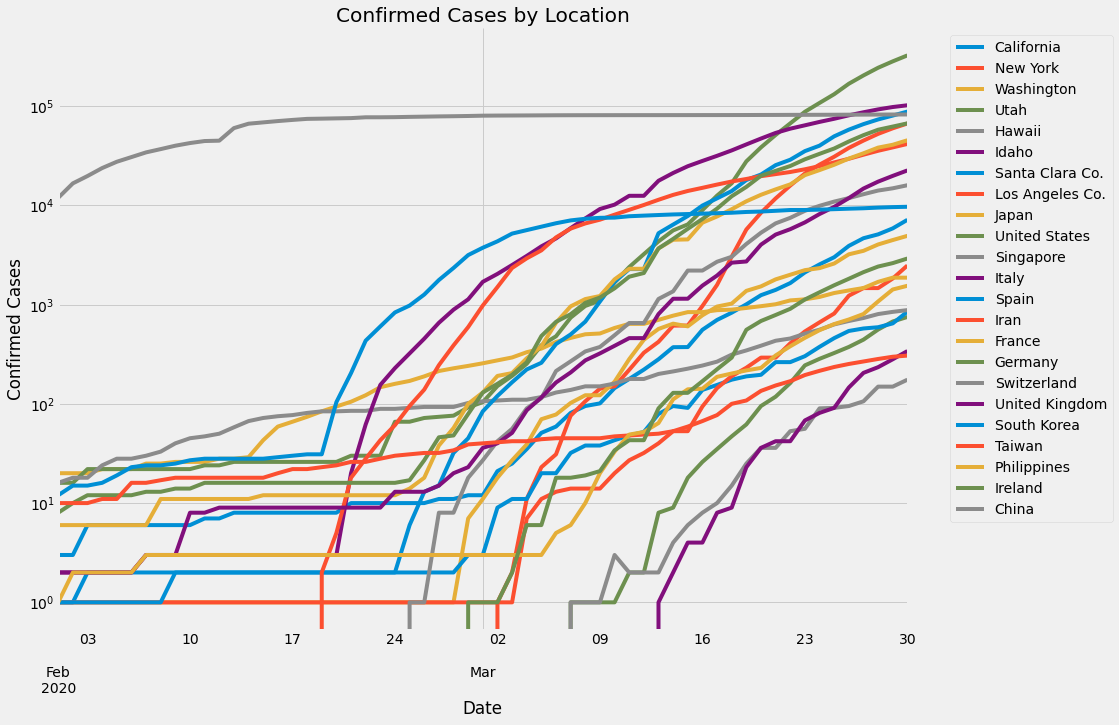

In [15]:
#newdf.loc['2/1/20':,:].plot(logy=True)
df.plot(logy=True)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.title("Confirmed Cases by Location")
plt.ylabel("Confirmed Cases")
sns.despine()

# TEMP ONLY
Drop rows that have data glitches

In [16]:
#df = df.drop(labels=['3/22/20', '3/30/20'], axis=0)

# Graph raw data

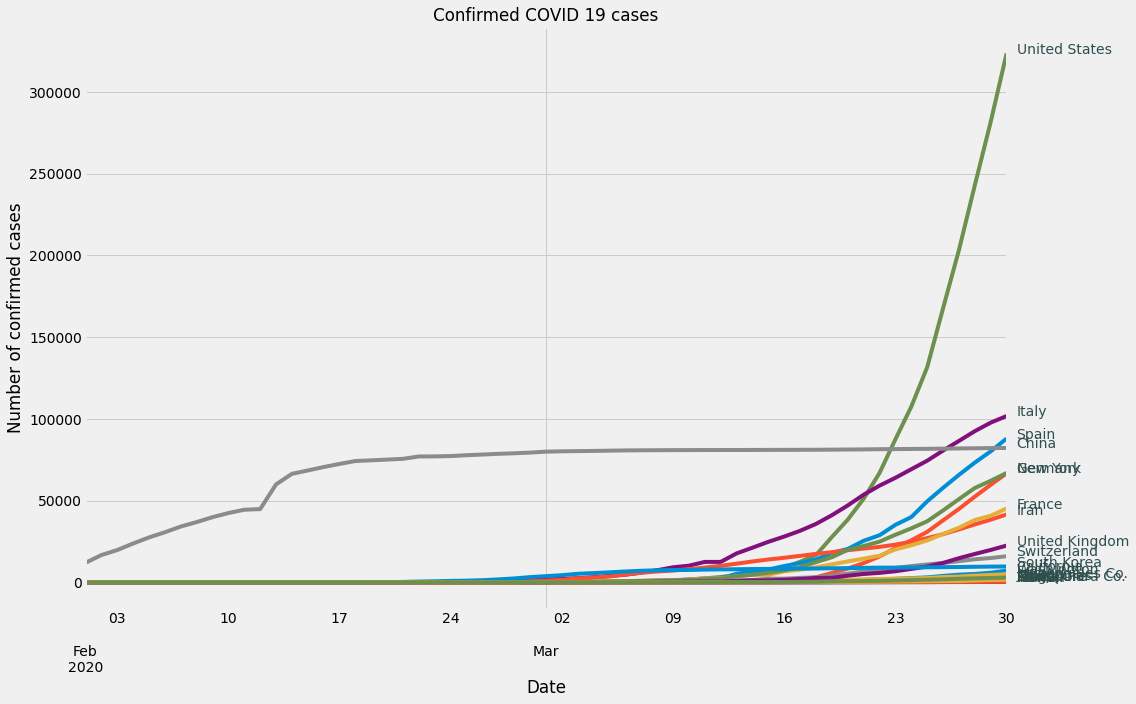

In [17]:
def label_lines(df, ax, use_simple_x_axis=False):
    '''Labels lines in a chart assuming that some lines will be different lengths than others'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')


        
graph_data = df
#graph_data = df.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot(legend=False)
ax.set_title('Confirmed COVID 19 cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
label_lines(graph_data, ax)
plt.tight_layout()
plt.show()

# Create a 'days since 100 cases' graph

In [18]:
df.head(2)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,20.0,16.0,...,0.0,6.0,8.0,0.0,2.0,12.0,10.0,1.0,0.0,11891.0
2020-02-02,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,20.0,16.0,...,0.0,6.0,10.0,0.0,2.0,15.0,10.0,2.0,0.0,16630.0


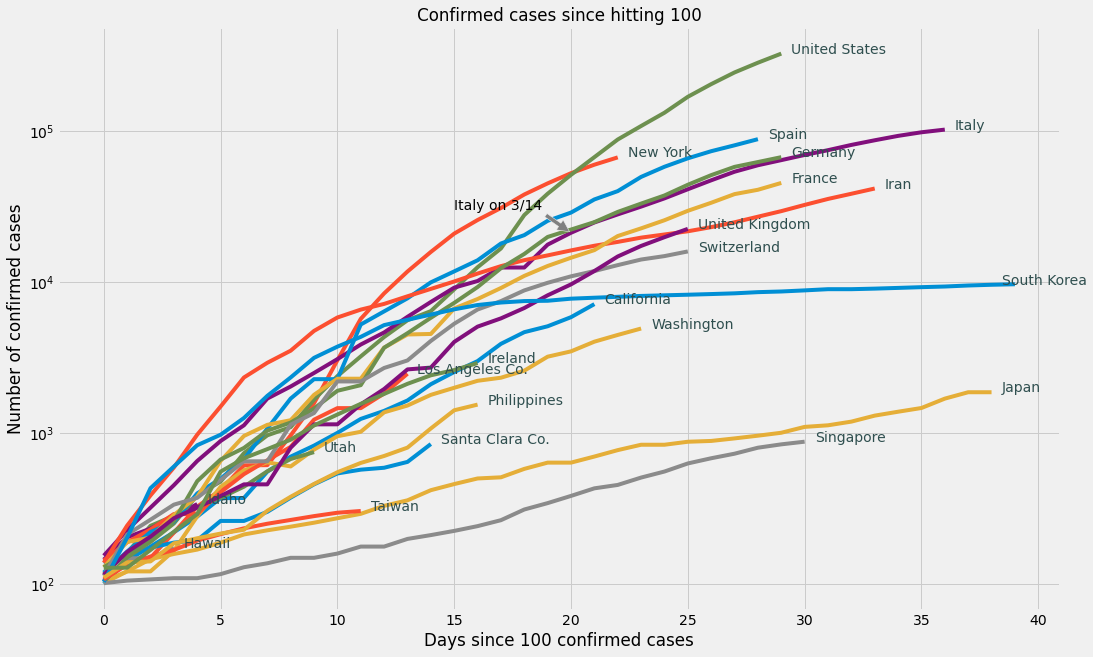

In [19]:
threshold = 100
daysSince100 = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
            arrowprops=dict(facecolor='grey', shrink=0.05),)


for location in daysSince100.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSince100[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSince100[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
            
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
        

# Cases relative to Population

In [20]:
per = 100000

popdf = pd.DataFrame(index = df.index,
                     data = {
                         'California': 39747267,
                         'New York': 19491339,
                         'Washington': 7797095,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Idaho': 1826156,
                         'Santa Clara Co.': 2200000,
                         'Los Angeles Co.': 10500000,
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Spain': 46754778,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'China': 1439323776,
                         
                     }

)
popdf

casesperdf = df.div(popdf).mul(per)
casesperdf

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,0.007548,0.000000,0.012825,0.000000,0.000000,0.000000,0.045455,0.009524,0.015813,0.004834,...,0.000000,0.009192,0.009548,0.000000,0.002946,0.023406,0.041987,0.000913,0.000000,0.826152
2020-02-02,0.007548,0.000000,0.012825,0.000000,0.000000,0.000000,0.045455,0.009524,0.015813,0.004834,...,0.000000,0.009192,0.011935,0.000000,0.002946,0.029257,0.041987,0.001825,0.000000,1.155404
2020-02-03,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.009524,0.015813,0.006646,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.029257,0.041987,0.001825,0.000000,1.369810
2020-02-04,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.009524,0.017395,0.006646,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.031208,0.046186,0.001825,0.000000,1.647093
2020-02-05,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.009524,0.017395,0.006646,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.037059,0.046186,0.001825,0.000000,1.906451
2020-02-06,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.009524,0.017395,0.006646,...,0.000000,0.009192,0.014323,0.000000,0.002946,0.044861,0.067180,0.001825,0.000000,2.125095
2020-02-07,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.009524,0.019767,0.006646,...,0.000000,0.009192,0.015516,0.000000,0.004419,0.046812,0.067180,0.002738,0.000000,2.369863
2020-02-08,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.009524,0.019767,0.006646,...,0.000000,0.016852,0.015516,0.000000,0.004419,0.046812,0.071378,0.002738,0.000000,2.557729
2020-02-09,0.015095,0.000000,0.012825,0.000000,0.000000,0.000000,0.090909,0.009524,0.020557,0.006646,...,0.000000,0.016852,0.016710,0.000000,0.004419,0.048762,0.075577,0.002738,0.000000,2.767202


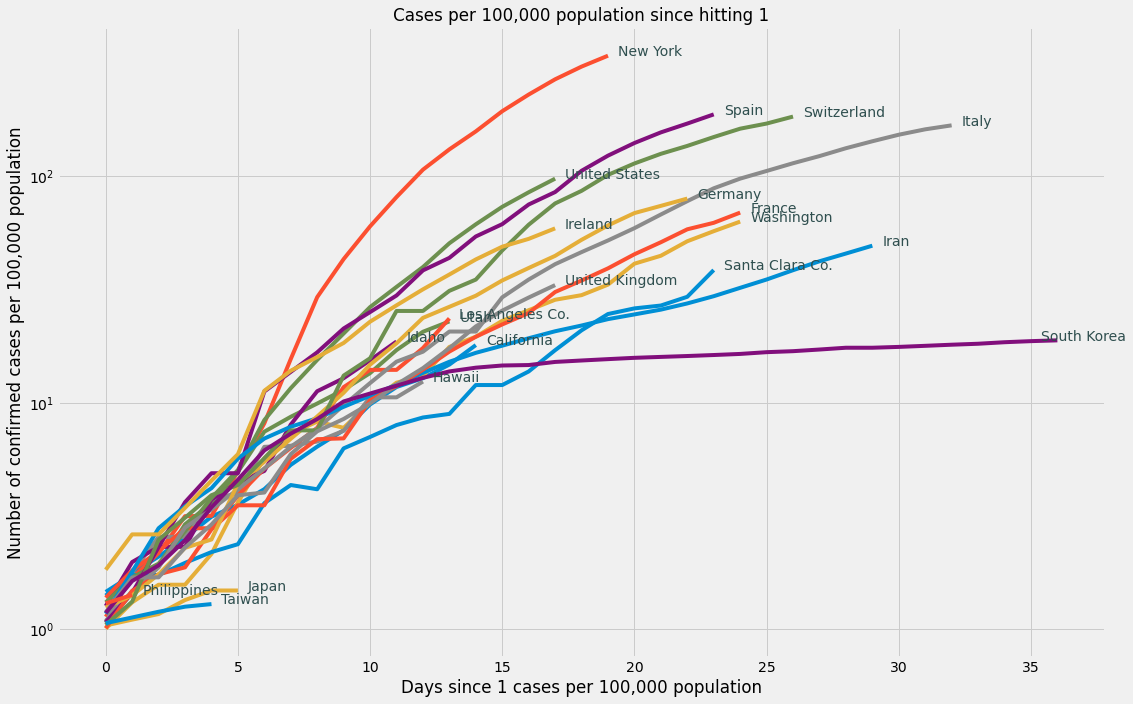

In [22]:
threshold = 1
daysSincerate = pd.DataFrame(index=range(0,len(casesperdf.index)))
for location in casesperdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesperdf.loc[date, location] 
                              for date in casesperdf[location].index 
                              if casesperdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


daysSincerate = daysSincerate.drop(['China','Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per {:,} population since hitting {}'.format(per, threshold), fontsize='large')
ax.set_xlabel('Days since {} cases per {:,} population'.format(threshold, per), fontsize='large')
ax.set_ylabel('Number of confirmed cases per {:,} population'.format(per), fontsize='large')
#ax.annotate("Italy on 3/14", xy=(16,34.99), xytext=(25, 24),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

for location in daysSincerate.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSincerate[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSincerate[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
plt.tight_layout()
plt.show()
        

In [23]:
daysSince100

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Spain,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland
0,101.0,106.0,102.0,118.0,106.0,146.0,138.0,144.0,105.0,104.0,...,120.0,139.0,130.0,130.0,114.0,116.0,104.0,108.0,111.0,129.0
1,144.0,142.0,122.0,162.0,149.0,205.0,155.0,190.0,122.0,151.0,...,165.0,245.0,191.0,159.0,214.0,164.0,204.0,135.0,140.0,129.0
2,178.0,150.0,122.0,244.0,149.0,234.0,175.0,231.0,147.0,191.0,...,222.0,388.0,204.0,196.0,268.0,207.0,433.0,153.0,142.0,169.0
3,221.0,220.0,167.0,284.0,175.0,281.0,189.0,292.0,159.0,253.0,...,259.0,593.0,288.0,262.0,337.0,274.0,602.0,169.0,187.0,223.0
4,281.0,327.0,282.0,325.0,NaN,340.0,196.0,292.0,170.0,389.0,...,400.0,978.0,380.0,482.0,374.0,322.0,833.0,195.0,202.0,292.0
5,372.0,421.0,442.0,374.0,NaN,NaN,263.0,407.0,189.0,479.0,...,500.0,1501.0,656.0,670.0,491.0,384.0,977.0,215.0,217.0,557.0
6,373.0,613.0,568.0,443.0,NaN,NaN,263.0,536.0,214.0,738.0,...,673.0,2336.0,959.0,799.0,652.0,459.0,1261.0,235.0,230.0,683.0
7,557.0,615.0,642.0,560.0,NaN,NaN,302.0,662.0,228.0,968.0,...,1073.0,2922.0,1136.0,1040.0,652.0,459.0,1766.0,252.0,307.0,785.0
8,700.0,967.0,603.0,675.0,NaN,NaN,375.0,812.0,241.0,1097.0,...,1695.0,3513.0,1219.0,1176.0,1139.0,802.0,2337.0,267.0,380.0,906.0
9,828.0,1578.0,779.0,750.0,NaN,NaN,459.0,1229.0,256.0,1667.0,...,2277.0,4747.0,1794.0,1457.0,1359.0,1144.0,3150.0,283.0,462.0,1125.0


# Look at growth factor changes

In [24]:
start_date = '2/27/20'
window = 3
location = ['California', 'Italy']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
df.loc[start_date:,:]

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-27,11.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,214.0,74.0,...,245.0,38.0,46.0,8.0,15.0,1766.0,32.0,3.0,0.0,78600.0
2020-02-28,11.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,228.0,76.0,...,388.0,57.0,48.0,8.0,20.0,2337.0,34.0,3.0,0.0,78928.0
2020-02-29,12.0,0.0,7.0,0.0,0.0,0.0,3.0,1.0,241.0,92.0,...,593.0,100.0,79.0,18.0,23.0,3150.0,39.0,3.0,1.0,79356.0
2020-03-01,12.0,0.0,11.0,0.0,0.0,0.0,3.0,1.0,256.0,104.0,...,978.0,130.0,130.0,27.0,36.0,3736.0,40.0,3.0,1.0,79932.0
2020-03-02,21.0,1.0,18.0,0.0,0.0,0.0,9.0,1.0,274.0,151.0,...,1501.0,191.0,159.0,42.0,40.0,4335.0,41.0,3.0,1.0,80136.0
2020-03-03,25.0,2.0,27.0,0.0,0.0,0.0,11.0,1.0,293.0,191.0,...,2336.0,204.0,196.0,56.0,51.0,5186.0,42.0,3.0,2.0,80261.0
2020-03-04,35.0,11.0,39.0,0.0,0.0,0.0,11.0,7.0,331.0,253.0,...,2922.0,288.0,262.0,90.0,86.0,5621.0,42.0,3.0,6.0,80386.0
2020-03-05,51.0,23.0,70.0,0.0,0.0,0.0,20.0,11.0,360.0,389.0,...,3513.0,380.0,482.0,114.0,116.0,6088.0,44.0,3.0,6.0,80537.0
2020-03-06,59.0,31.0,78.0,0.0,0.0,0.0,20.0,13.0,420.0,479.0,...,4747.0,656.0,670.0,214.0,164.0,6593.0,45.0,5.0,18.0,80690.0


In [25]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
df.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,inf,NaN,inf,NaN,NaN,NaN,inf,NaN,0.928571,8.000000,...,1.433566,2.263158,15.500000,inf,0.600000,1.423818,2.500000,NaN,inf,1.304878
2020-03-01,0.000000,NaN,0.666667,NaN,NaN,NaN,0.000000,NaN,1.153846,0.750000,...,1.878049,0.697674,1.645161,0.900000,4.333333,0.720787,0.200000,NaN,0.000000,1.345794
2020-03-02,inf,inf,1.750000,NaN,NaN,NaN,inf,NaN,1.200000,3.916667,...,1.358442,2.033333,0.568627,1.666667,0.307692,1.022184,1.000000,NaN,NaN,0.354167
2020-03-03,0.444444,1.000000,1.285714,NaN,NaN,NaN,0.333333,NaN,1.055556,0.851064,...,1.596558,0.213115,1.275862,0.933333,2.750000,1.420701,1.000000,NaN,inf,0.612745
2020-03-04,2.500000,9.000000,1.333333,NaN,NaN,NaN,0.000000,inf,2.000000,1.550000,...,0.701796,6.461538,1.783784,2.428571,3.181818,0.511163,0.000000,NaN,4.000000,1.000000
2020-03-05,1.600000,1.333333,2.583333,NaN,NaN,NaN,inf,0.666667,0.763158,2.193548,...,1.008532,1.095238,3.333333,0.705882,0.857143,1.073563,inf,NaN,0.000000,1.208000
2020-03-06,0.500000,0.666667,0.258065,NaN,NaN,NaN,0.000000,0.500000,2.068966,0.661765,...,2.087986,3.000000,0.854545,4.166667,1.600000,1.081370,0.500000,inf,inf,1.013245


In [26]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
#tempdf = df.drop('3/12/20', axis='index')
tempdf = df
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Santa Clara Co.,Los Angeles Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,Taiwan,Philippines,Ireland,China
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,inf,NaN,inf,NaN,NaN,NaN,inf,NaN,0.928571,8.000000,...,1.433566,2.263158,15.500000,inf,0.600000,1.423818,2.500000,NaN,inf,1.304878
2020-03-01,0.000000,NaN,0.666667,NaN,NaN,NaN,0.000000,NaN,1.153846,0.750000,...,1.878049,0.697674,1.645161,0.900000,4.333333,0.720787,0.200000,NaN,0.000000,1.345794
2020-03-02,inf,inf,1.750000,NaN,NaN,NaN,inf,NaN,1.200000,3.916667,...,1.358442,2.033333,0.568627,1.666667,0.307692,1.022184,1.000000,NaN,NaN,0.354167
2020-03-03,0.444444,1.000000,1.285714,NaN,NaN,NaN,0.333333,NaN,1.055556,0.851064,...,1.596558,0.213115,1.275862,0.933333,2.750000,1.420701,1.000000,NaN,inf,0.612745
2020-03-04,2.500000,9.000000,1.333333,NaN,NaN,NaN,0.000000,inf,2.000000,1.550000,...,0.701796,6.461538,1.783784,2.428571,3.181818,0.511163,0.000000,NaN,4.000000,1.000000
2020-03-05,1.600000,1.333333,2.583333,NaN,NaN,NaN,inf,0.666667,0.763158,2.193548,...,1.008532,1.095238,3.333333,0.705882,0.857143,1.073563,inf,NaN,0.000000,1.208000
2020-03-06,0.500000,0.666667,0.258065,NaN,NaN,NaN,0.000000,0.500000,2.068966,0.661765,...,2.087986,3.000000,0.854545,4.166667,1.600000,1.081370,0.500000,inf,inf,1.013245


Text(0.5, 1.0, 'Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n(3 day moving average)')

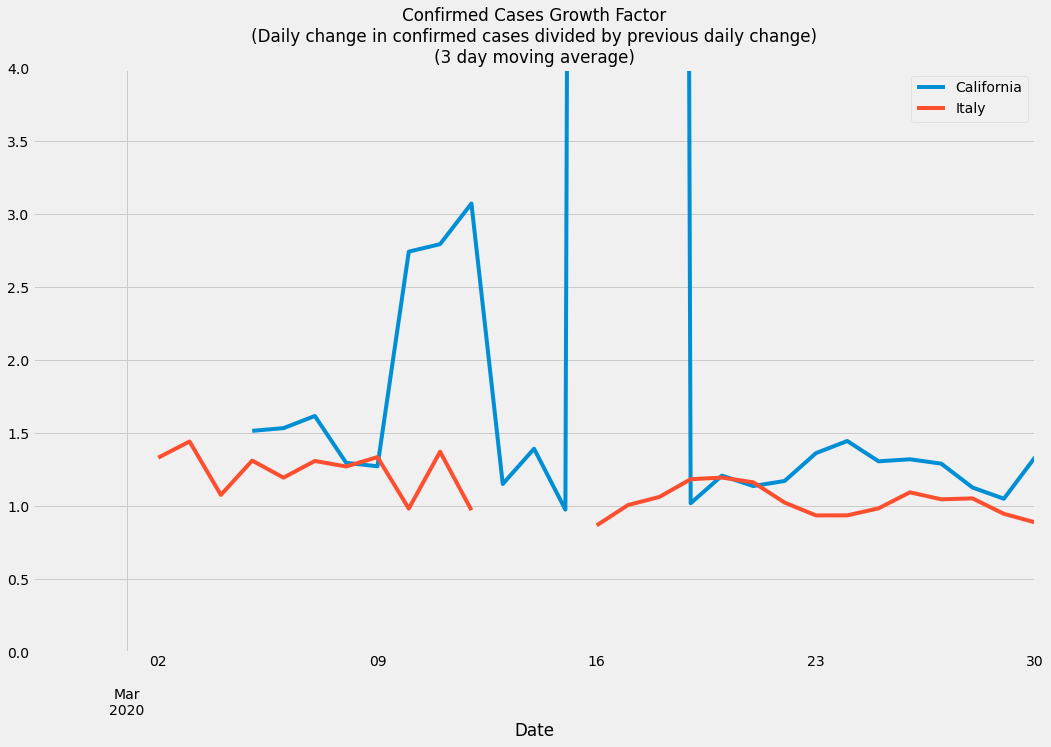

In [27]:
# graph the growth factors
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
ax.set_ylim(ymin=0, ymax=4)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')